# Setup


## Imports


In [11]:
import os

In [12]:
import numpy as np
import scipy
from scipy.stats import binned_statistic, binned_statistic_2d
import pandas as pd

In [13]:
import matplotlib
from matplotlib import patheffects
import matplotlib.pyplot as plt
import seaborn as sns

## Parameters


In [14]:
config = {
    "dir": "../../outputs/librarian=S2",
    "figure_dir": "../../analysis_data/figures",
    "bins": 16,
    "min_bin_percentile": 1,
    "min_bin_percentile_for_cpy": 10,
    "min_diff": 2,
    "left_density": "SciBERT",
    "right_density": "Word2Vec",
}

In [15]:
key_to_field = {
    'Bacon2019': 'Philosophy',
    'hafenLowredshiftLymanLimit2017': 'Physics',
    'Imeletal2022': 'Linguistics',
    'Ololube2012': 'Education',
    'Torres2013': 'Medicine',
    'West2003': 'Economics',
    'Miele2022': 'Materials Science',
    'ForeroOrtega2021': 'Geology',
    'Andre2018': 'Mathematics',
}

In [16]:
sns.set_style("white")

# Data Preprocessing


In [17]:
# Ensure we don't have any old dataframes
try:
    del df_combined
except NameError:
    pass
# Main loop
for i, vectorizer_dir in enumerate(os.listdir(config["dir"])):

    # Combine same vectorizer, different centers
    dfs = []
    for j, center_dir in enumerate(
        os.listdir(os.path.join(config["dir"], vectorizer_dir))
    ):
        # Open
        fp = os.path.join(config["dir"], vectorizer_dir, center_dir, "all_data.csv")
        df = pd.read_csv(fp)

        # Skip dfs with no identifier
        try:
            df = df.set_index("identifier")
        except KeyError:
            continue

        # Store center
        center = center_dir.split("=")[-1]
        df["center"] = center
        df["field"] = key_to_field[center]

        # Add df to list
        dfs.append(df)

    # Combine across centers
    if len(dfs) == 0:
        continue
    df = pd.concat(dfs)

    # Rename columns
    vectorizer = vectorizer_dir.split("=")[-1]
    for col in ["density", "edginess"]:
        df[f"{col}_{vectorizer}"] = df[col]
        del df[col]

    # Combine across vectorizers
    try:
        df_combined = df_combined.join(
            df.drop(
                columns=[
                    "citations_per_year",
                    "year",
                    "references",
                    "is_center",
                    "center",
                    "field",
                ]
            ),
            how="left",
        )
    except NameError:
        df_combined = df

In [18]:
# Drop rows with missing data or duplicates
df_combined = df_combined.dropna(
    axis="index",
    how="any",
    subset=[f"density_{config['left_density']}", f"density_{config['right_density']}"],
)
df_combined = df_combined.loc[~df_combined.index.duplicated()]

In [19]:
# Calculate percentiles for density vars
quantiles = np.linspace(0, 1, config["bins"] + 1)
density_vars = [var for var in df_combined.columns if "density" in var]
density_bins = {}
for var in density_vars:

    # Get density
    density = df_combined[var].values

    # Get density bins
    bins = np.linspace(
        np.nanpercentile(density, config["min_bin_percentile"]),
        np.nanpercentile(density, 100 - config["min_bin_percentile"]),
        config["bins"],
    )
    density_bins[var] = bins

    # Calculate and use quantile bins
    vectorizer = var.split("_")[-1]
    bins = np.quantile(density, quantiles)
    df_combined.loc[:, f"bin_{vectorizer}"] = np.digitize(density, bins=bins)

In [20]:
# Isolate entries where the density differs by >= min_diff bin
df_combined["different_densities"] = (
        np.abs(df_combined[f"bin_{config['left_density']}"] -
               df_combined[f"bin_{config['right_density']}"])
    ) >= config["min_diff"]
df_combined["different_densities"].value_counts()

different_densities
True     65066
False    18699
Name: count, dtype: int64

In [21]:
grouped_df = df_combined.groupby("field")

# Visualization


## Pairwise histograms

In [22]:
def insufficient_data(x, ax):

    if x.notna().sum() == 0:
        ax.annotate(
            text=f"No data for {x.name}",
            xy=(0.5, 0.5),
            xycoords="axes fraction",
            xytext=(0, 0),
            textcoords="offset points",
            ha="center",
            va="center",
        )

        return True
    else:
        return False

In [23]:
def hist(x, **kwargs):

    if insufficient_data(x, plt.gca()):
        return

    bins = density_bins[x.name]
    sns.histplot(x, bins=bins, **kwargs)
    plt.xlim(bins[0], bins[-1])

In [24]:
def hist2d(x, y, **kwargs):

    if insufficient_data(x, plt.gca()):
        return
    if insufficient_data(y, plt.gca()):
        return

    x_bins = density_bins[x.name]
    y_bins = density_bins[y.name]
    sns.histplot(x=x, y=y, bins=(x_bins, y_bins), **kwargs)
    plt.xlim(x_bins[0], x_bins[-1])
    plt.ylim(y_bins[0], y_bins[-1])

Distribution of density for Economics


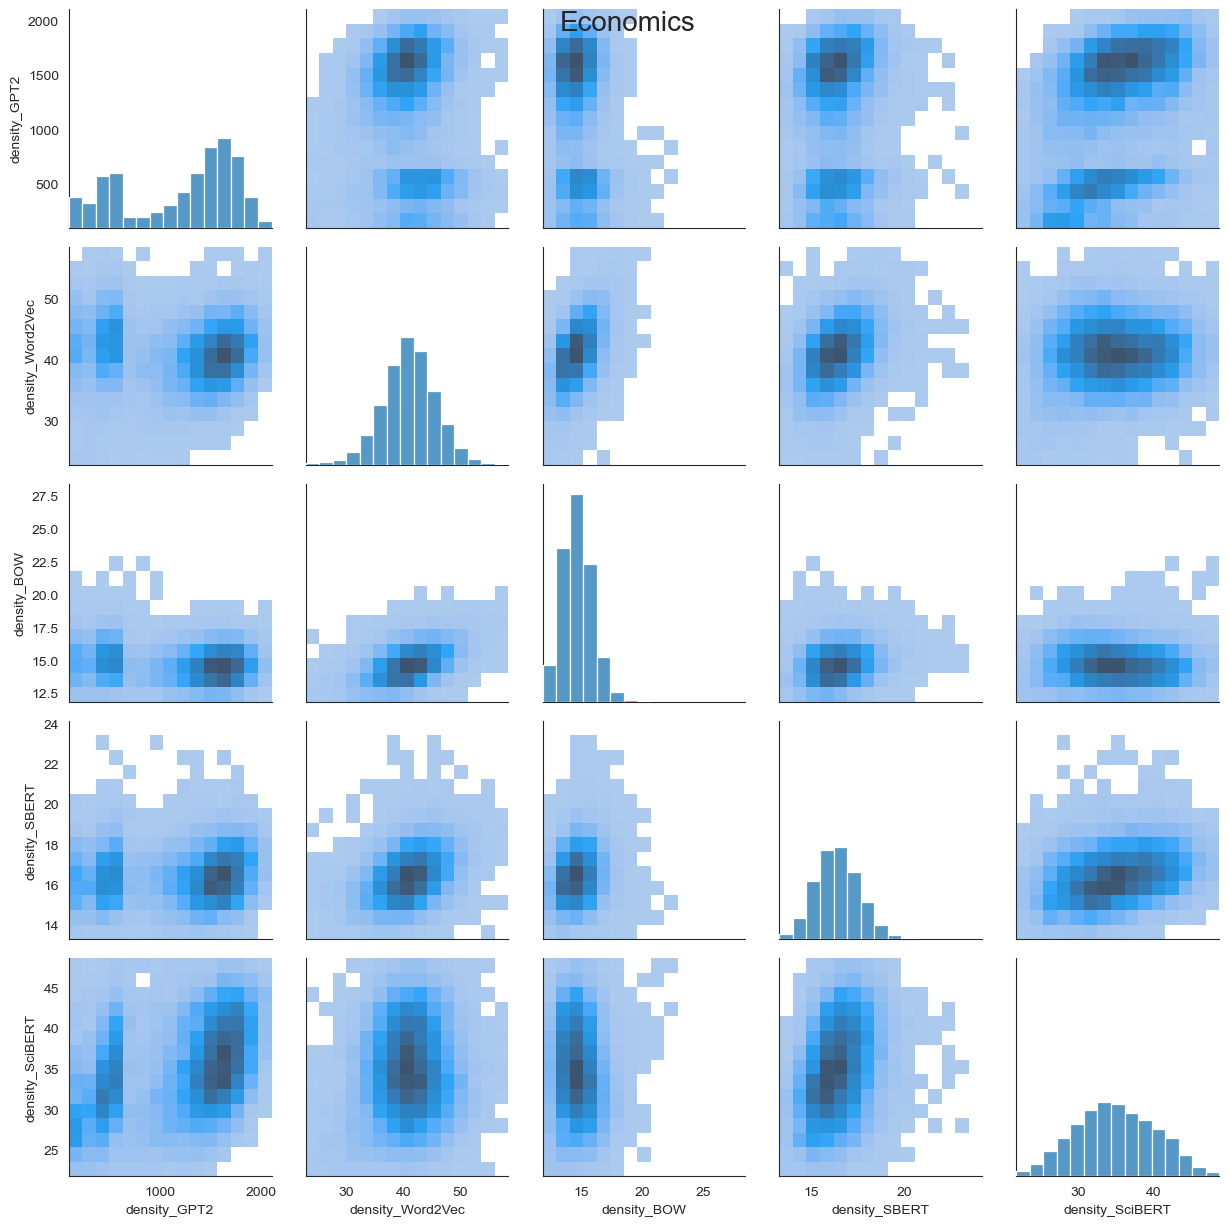

Distribution of density for Education


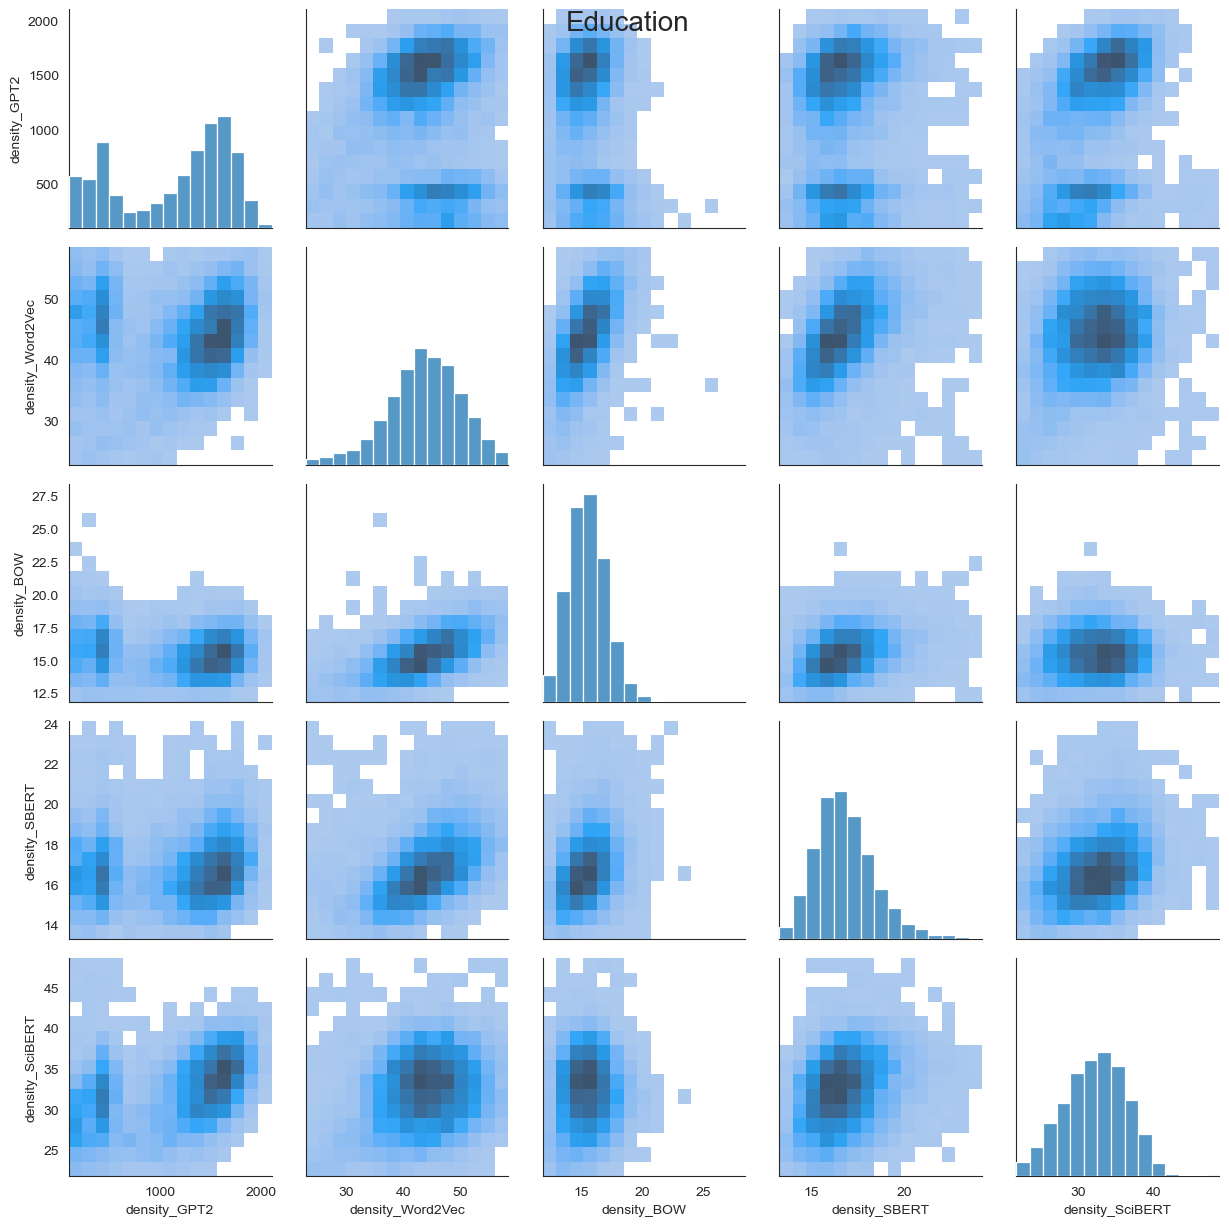

Distribution of density for Geology


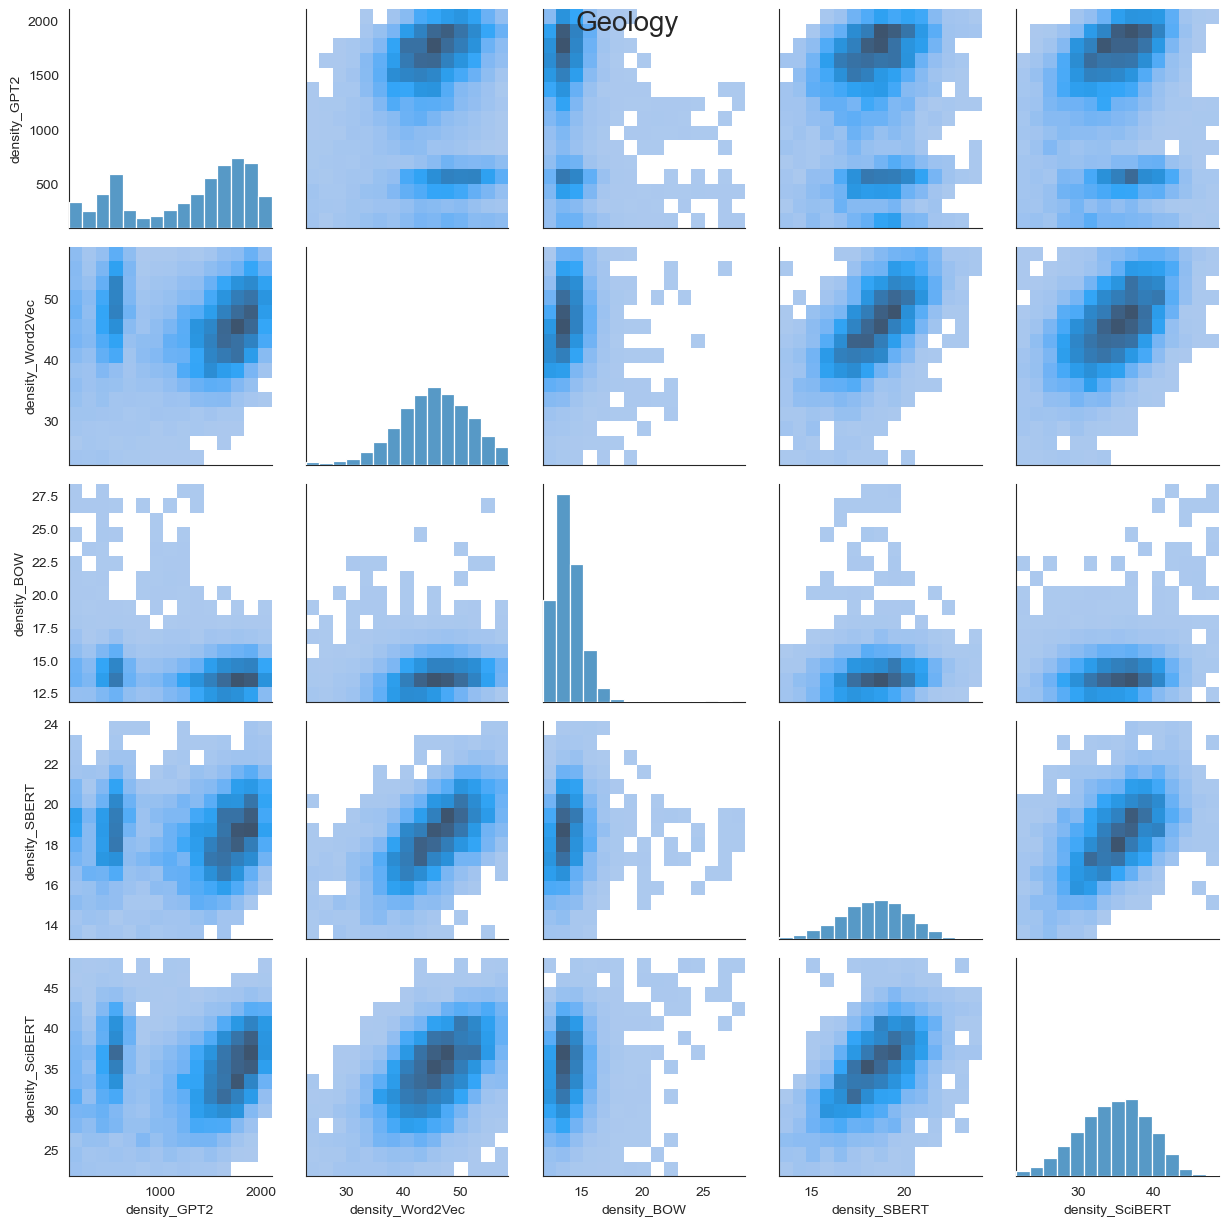

Distribution of density for Linguistics


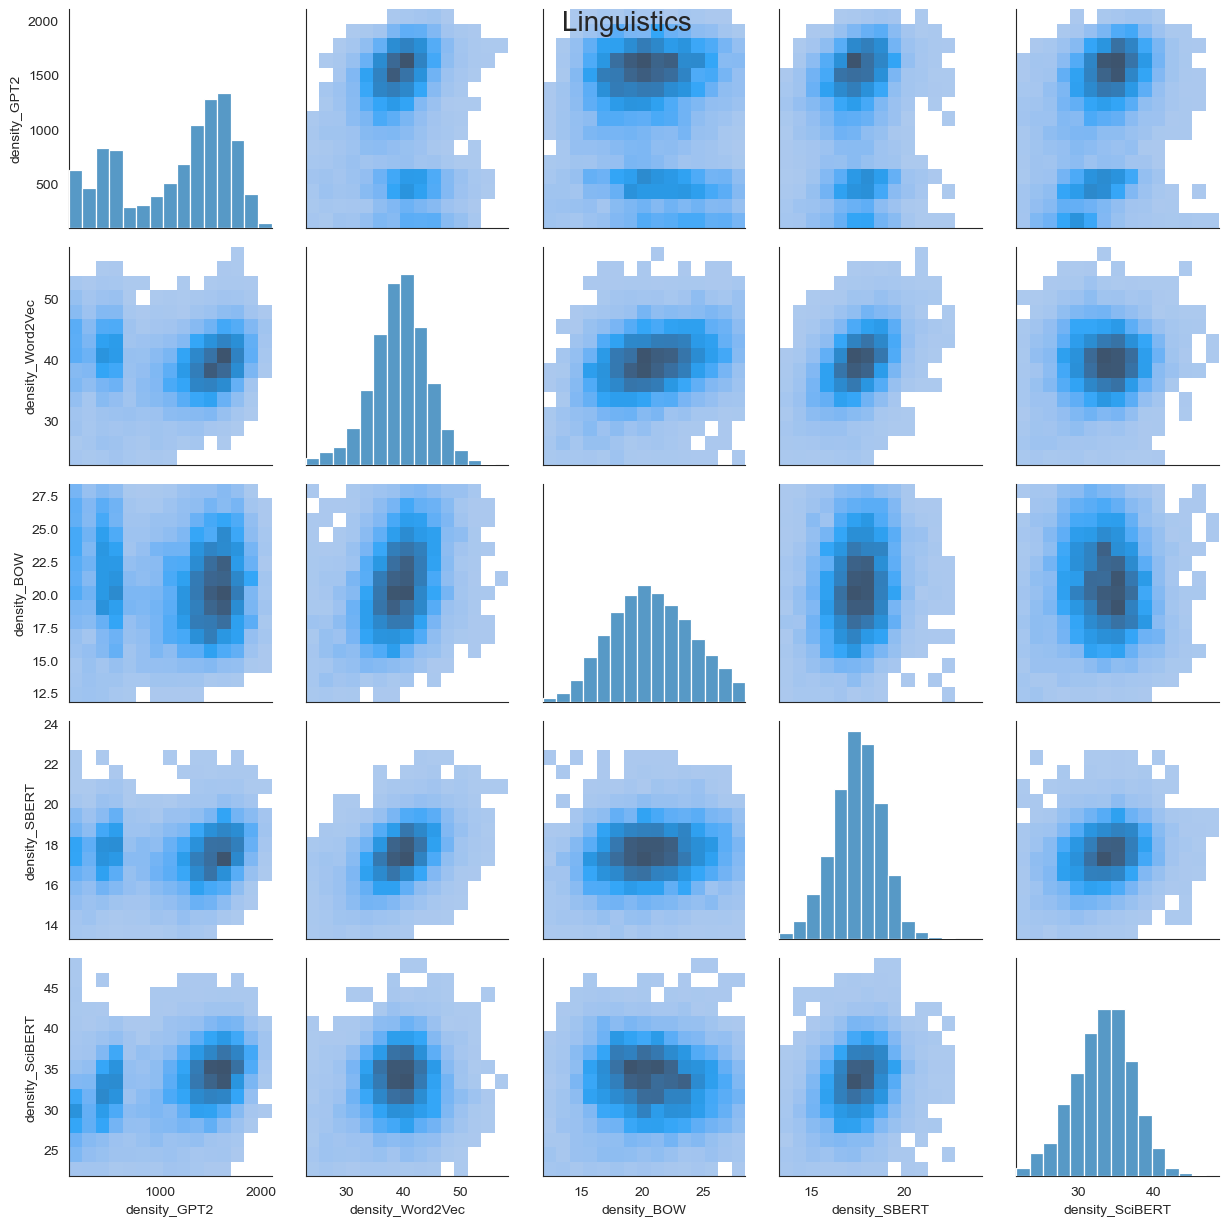

Distribution of density for Materials Science


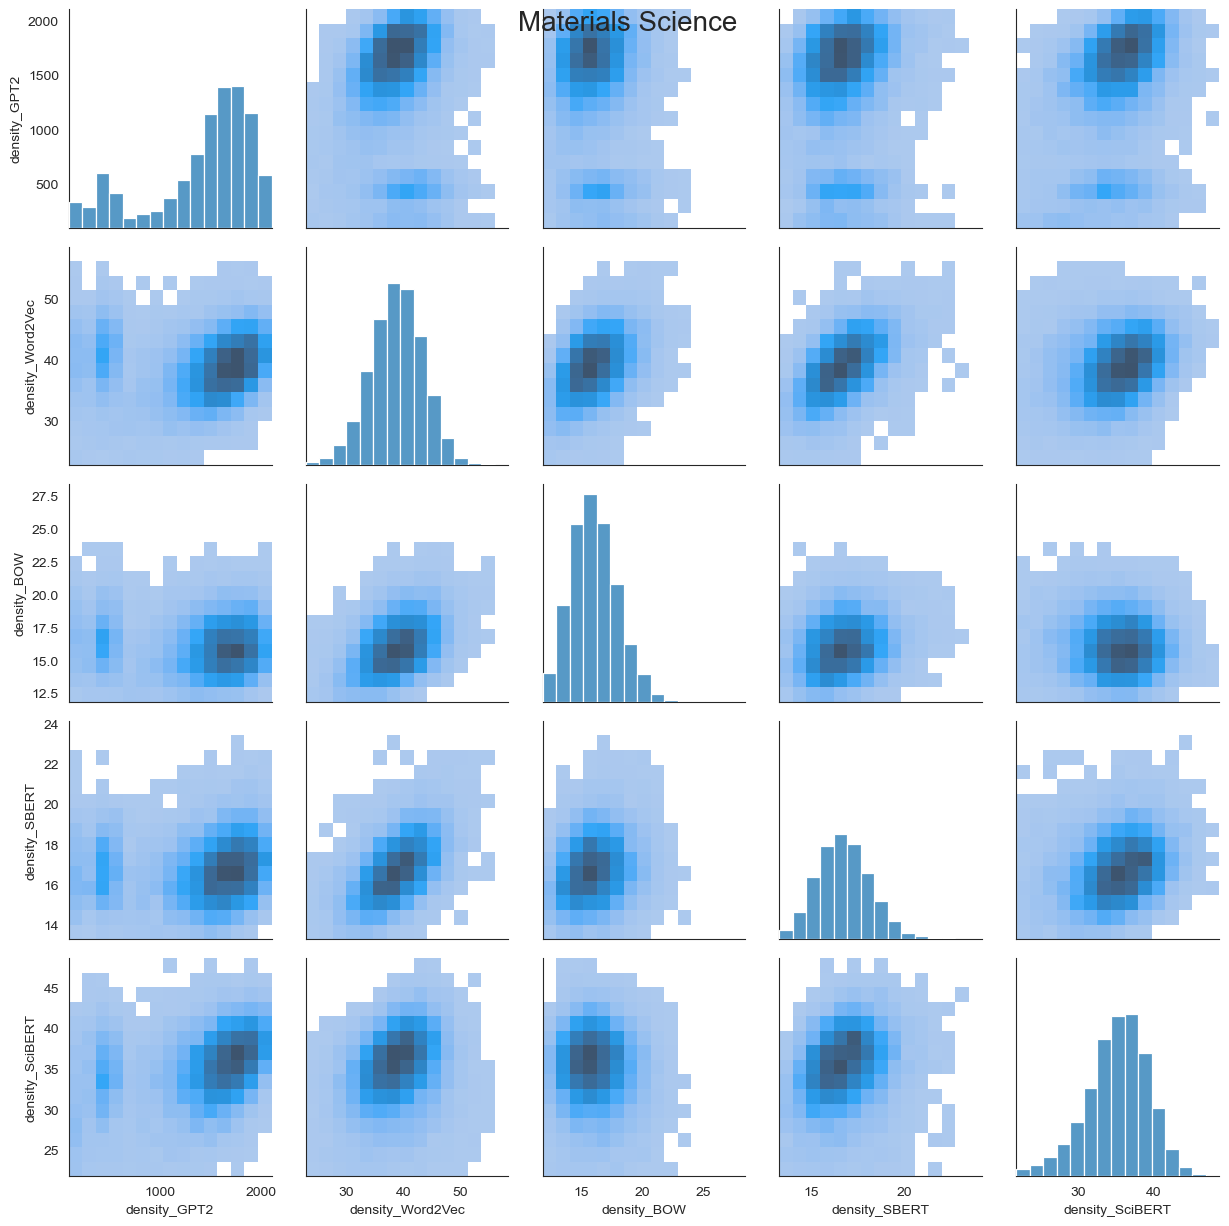

Distribution of density for Mathematics


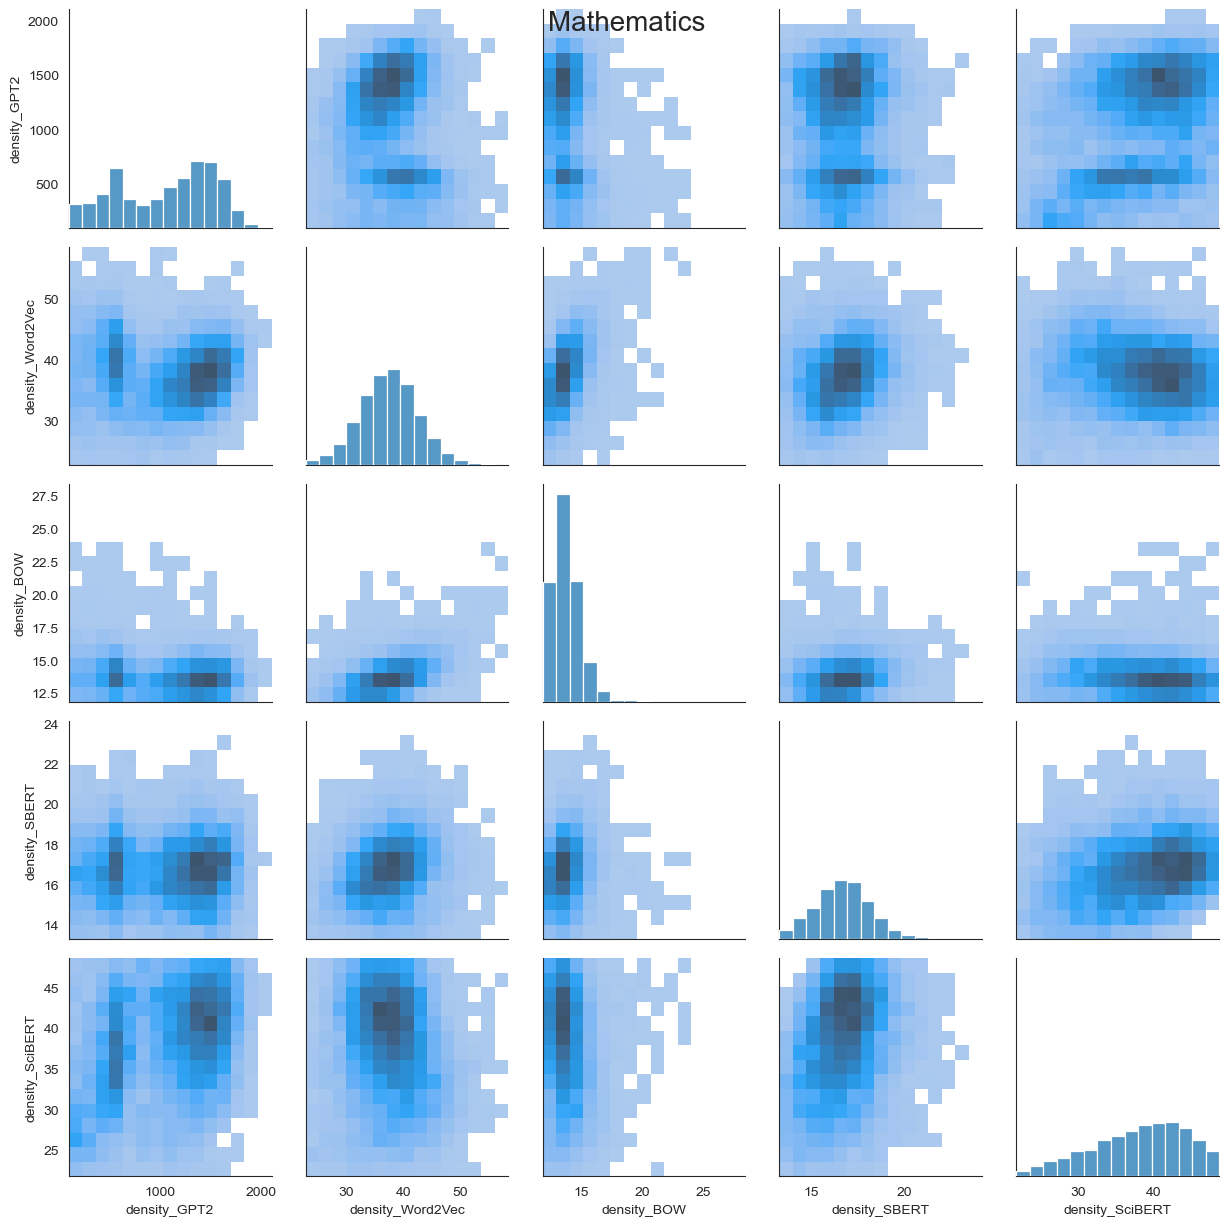

Distribution of density for Medicine


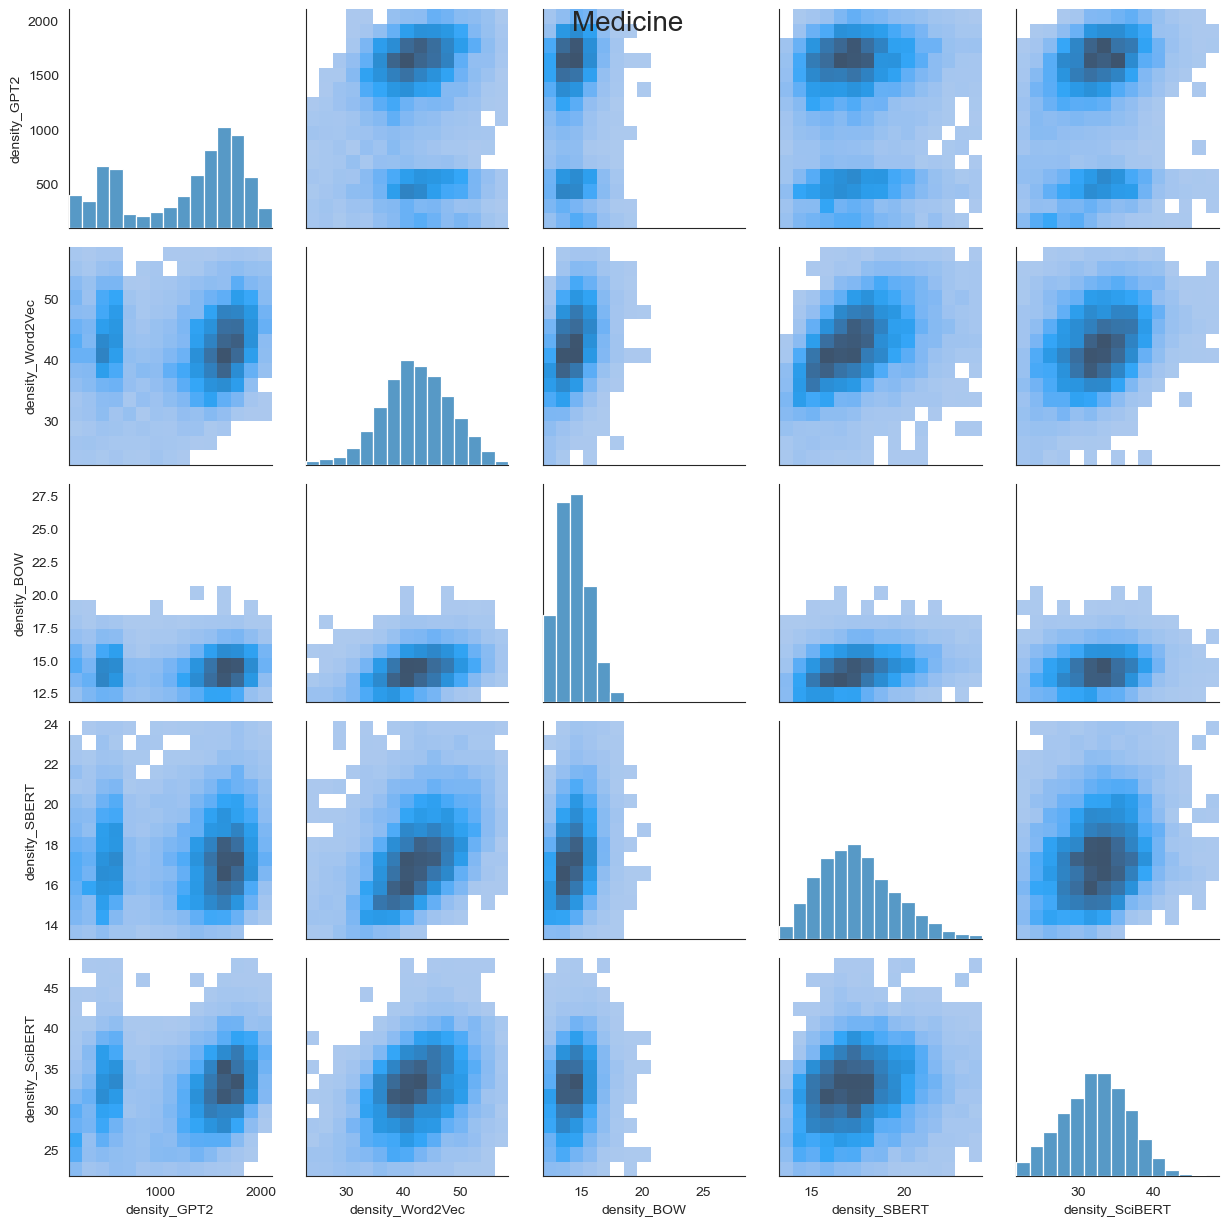

Distribution of density for Philosophy


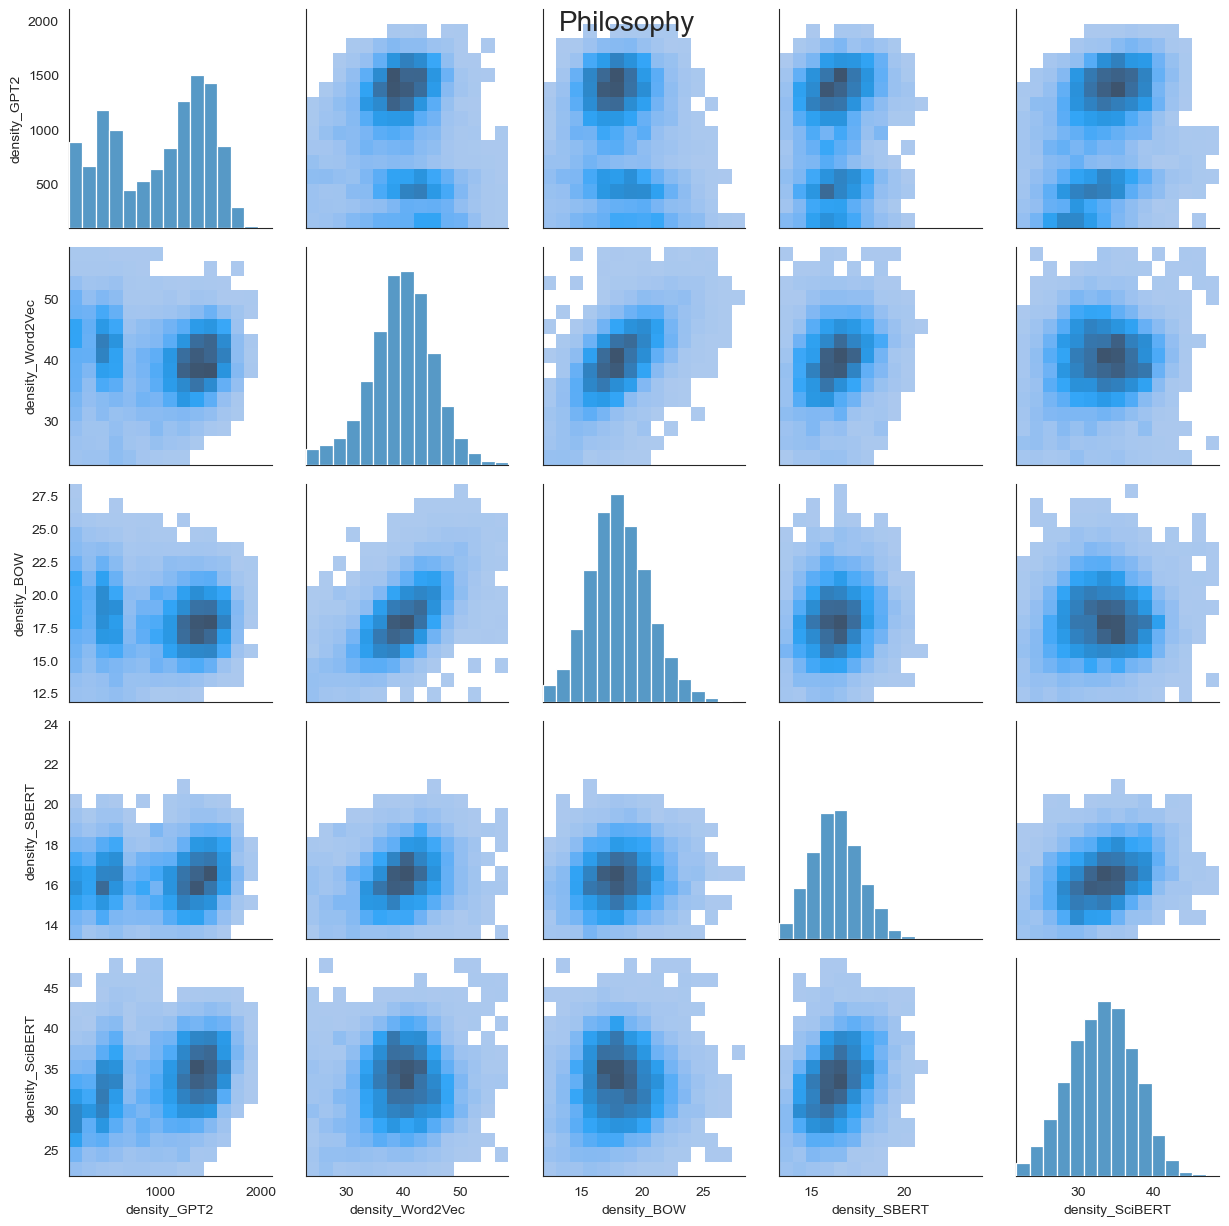

Distribution of density for Physics


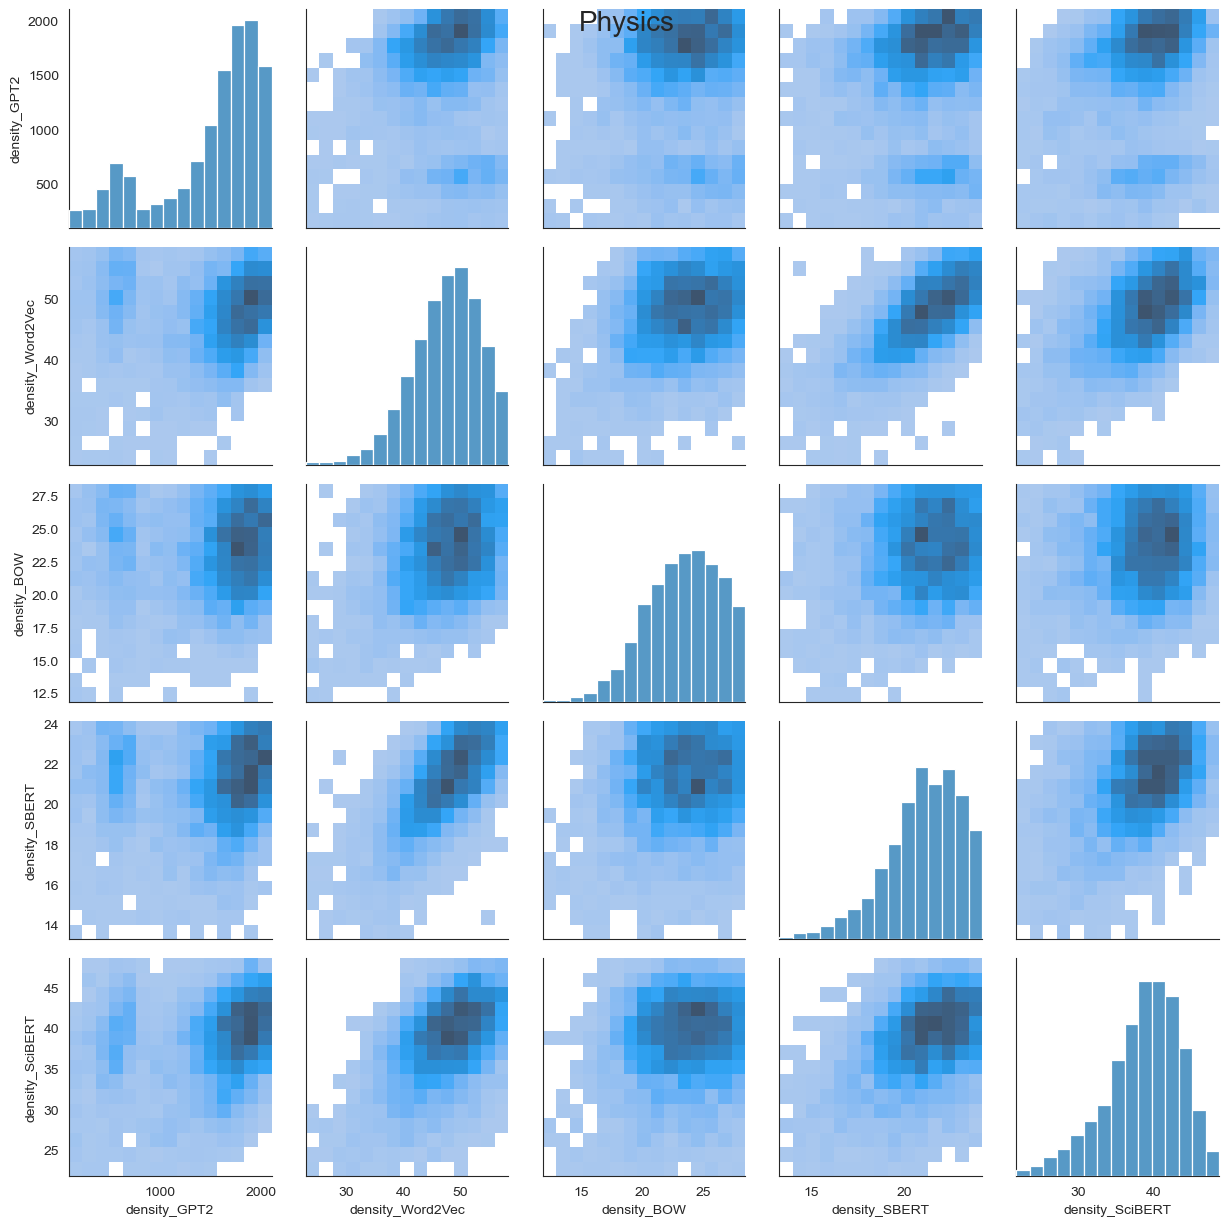

In [25]:
# Basic visualization
for field, group in grouped_df:

    print("Distribution of density for", field)

    g = sns.PairGrid(group, vars=density_vars)
    g.map_diag(hist)
    g.map_offdiag(hist2d)
    plt.suptitle(field, fontsize=20)
    plt.show()
    g.figure.savefig(
        os.path.join(config["figure_dir"], f"density_per_vectorizer_for_{field}.png")
    )

## Vs Citations

In [26]:
cpy_bins = np.linspace(
    np.nanpercentile(
        df_combined["citations_per_year"].dropna(), config["min_bin_percentile_for_cpy"]
    ),
    np.nanpercentile(
        df_combined["citations_per_year"].dropna(),
        100 - config["min_bin_percentile_for_cpy"],
    ),
    config["bins"],
)
cpy_median = df_combined["citations_per_year"].median()

In [27]:
def cpy_vs_density(x, cpy, **kwargs):

    if insufficient_data(x, plt.gca()):
        return

    ax = plt.gca()

    bins = density_bins[x.name]
    centers = (bins[1:] + bins[:-1]) / 2

    # Calculate running median
    median, bin_edges, bin_number = binned_statistic(
        x, cpy, statistic="median", bins=bins
    )
    ax.plot(
        centers,
        median,
        color="k",
    )

    # Calculate running percentiles
    low, bin_edges, bin_number = binned_statistic(
        x,
        cpy,
        statistic=lambda v: np.nanpercentile(v, 16),
        bins=bins,
    )
    high, bin_edges, bin_number = binned_statistic(
        x,
        cpy,
        statistic=lambda v: np.nanpercentile(v, 84),
        bins=bins,
    )
    ax.fill_between(
        centers,
        low,
        high,
        color="k",
        alpha=0.1,
    )

    ax.set_xlim(bins[0], bins[-1])

In [28]:
def median_cpy(x, y, cpy, **kwargs):

    if insufficient_data(x, plt.gca()):
        return
    if insufficient_data(y, plt.gca()):
        return

    x_bins = density_bins[x.name]
    y_bins = density_bins[y.name]

    def _excess_above_median(z):

        return (z > cpy.median()).sum() - z.size / 2

    statistic, x_edges, y_edges, binnumber = binned_statistic_2d(
        x,
        y,
        cpy,
        bins=[x_bins, y_bins],
        statistic=_excess_above_median,
    )

    ax = plt.gca()

    ax.pcolormesh(
        x_edges,
        y_edges,
        statistic.T,
        shading="auto",
        vmin=-len(x) / 2 / config["bins"] ** 2,
        vmax=len(x) / 2 / config["bins"] ** 2,
        cmap=sns.color_palette("vlag", as_cmap=True),
        linewidth=0.0001,
        **kwargs,
    )

    ax.set_xlim(x_bins[0], x_bins[-1])
    ax.set_ylim(y_bins[0], y_bins[-1])


Distribution of cpy vs density for Economics


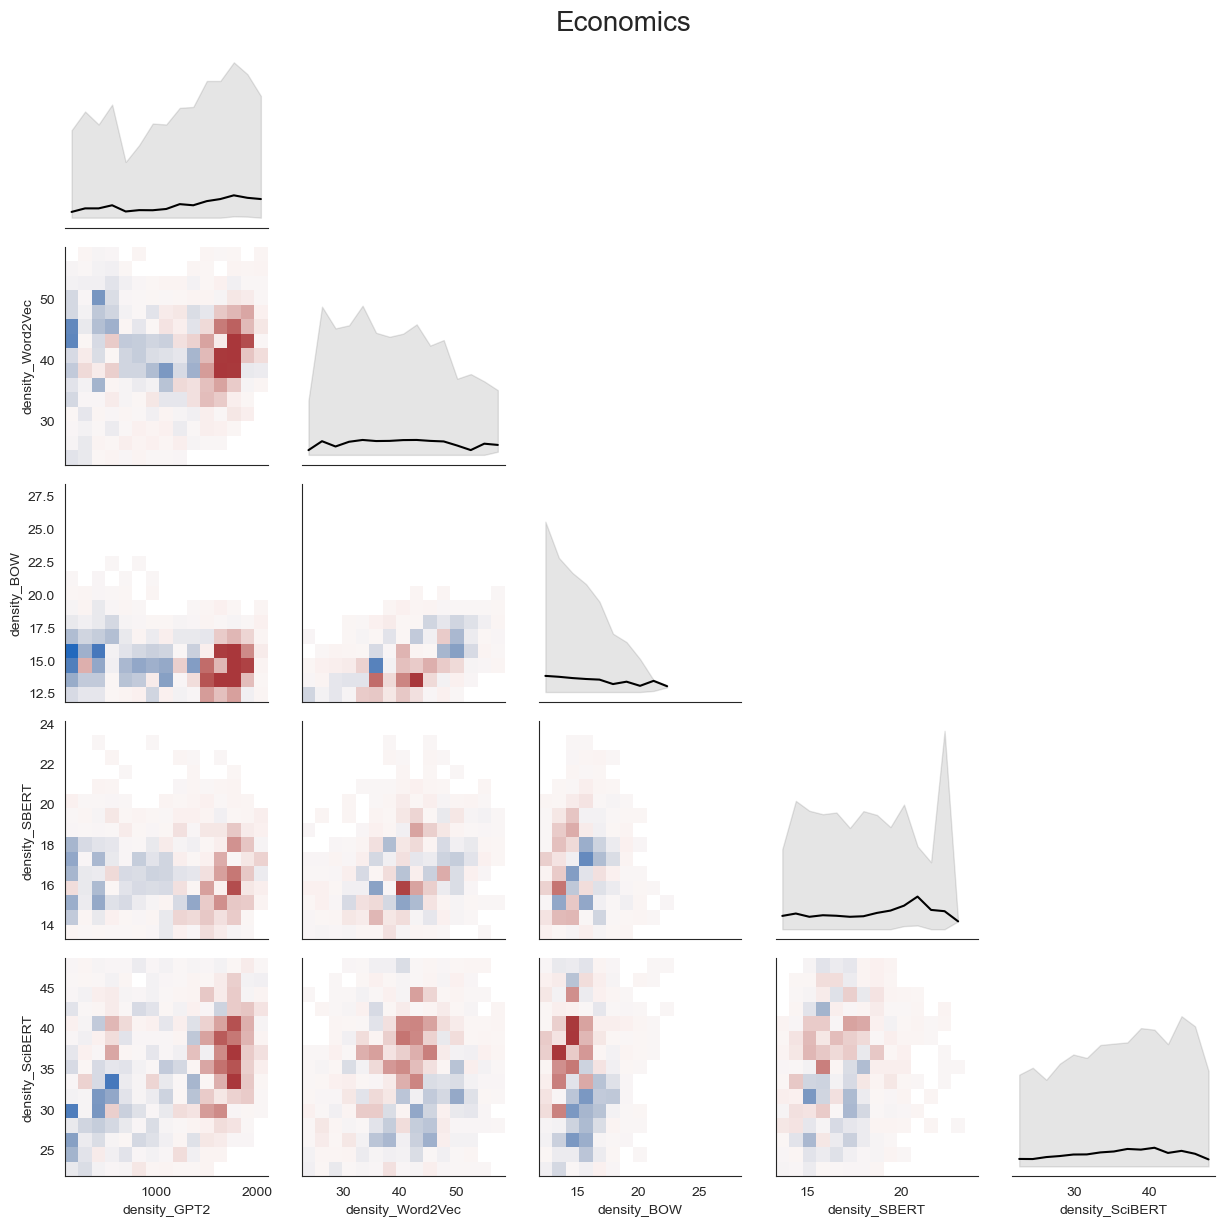

Distribution of cpy vs density for Education


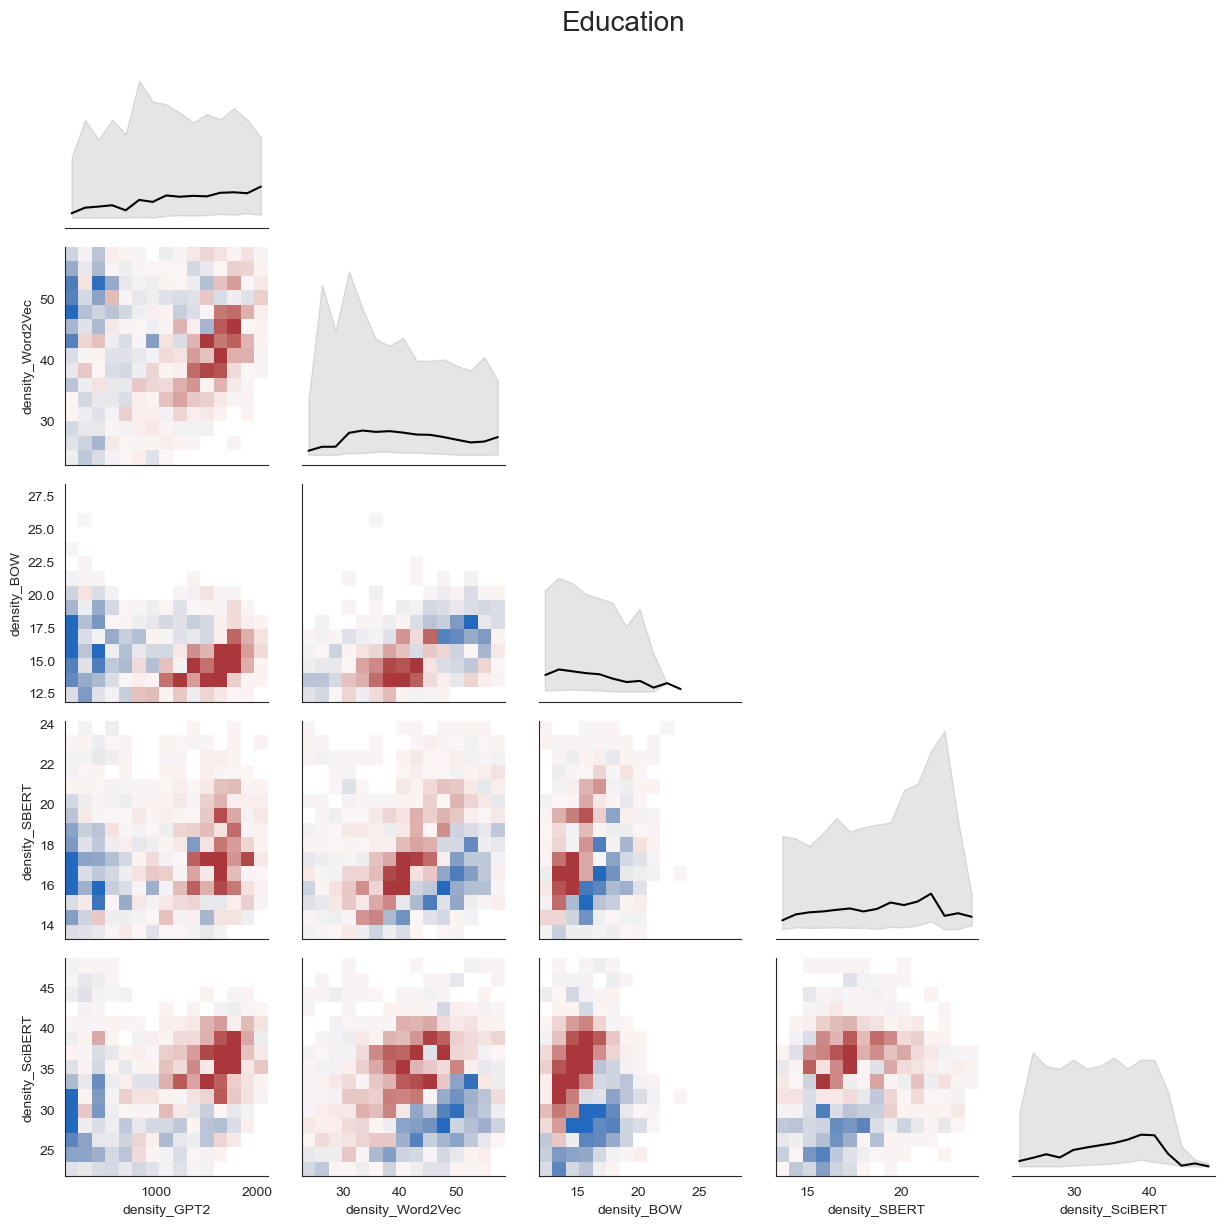

Distribution of cpy vs density for Geology


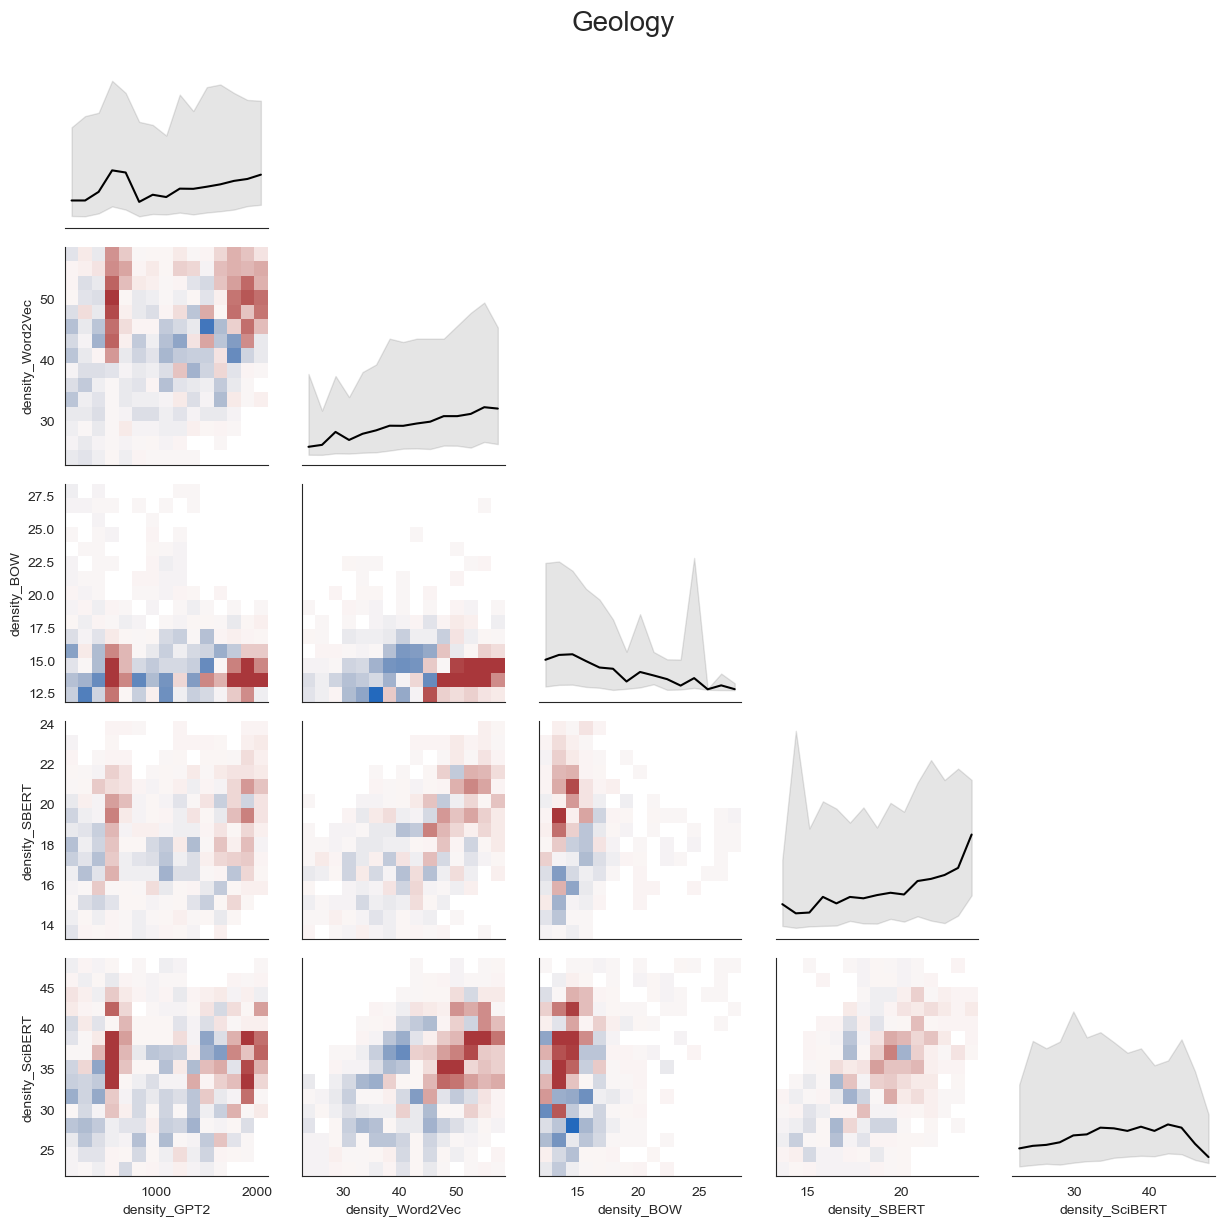

Distribution of cpy vs density for Linguistics


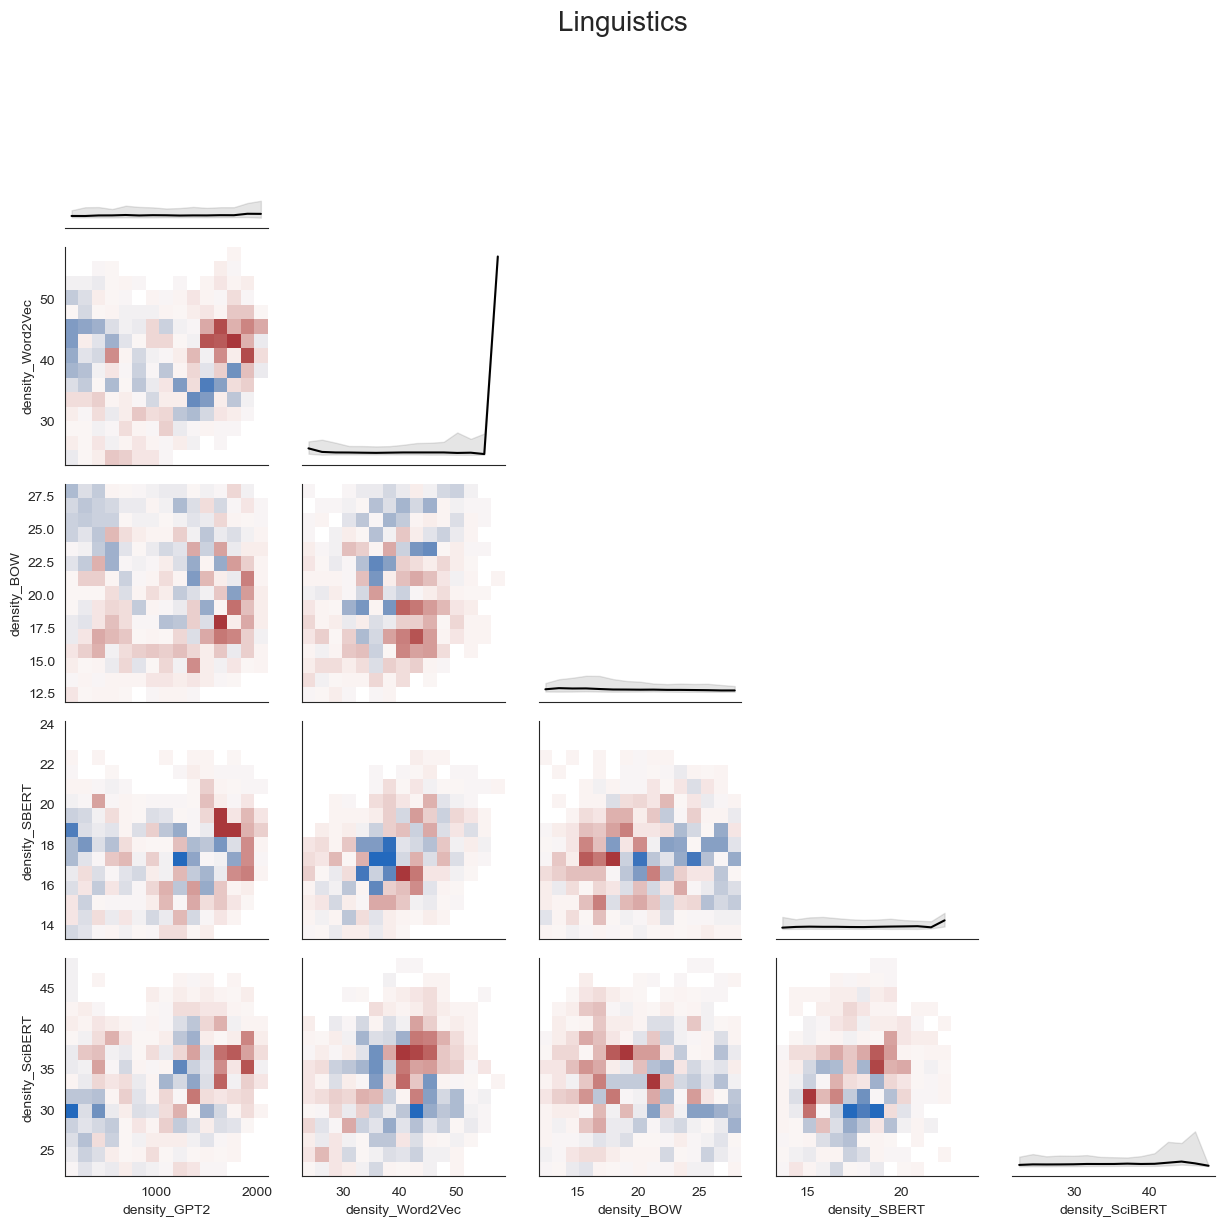

Distribution of cpy vs density for Materials Science


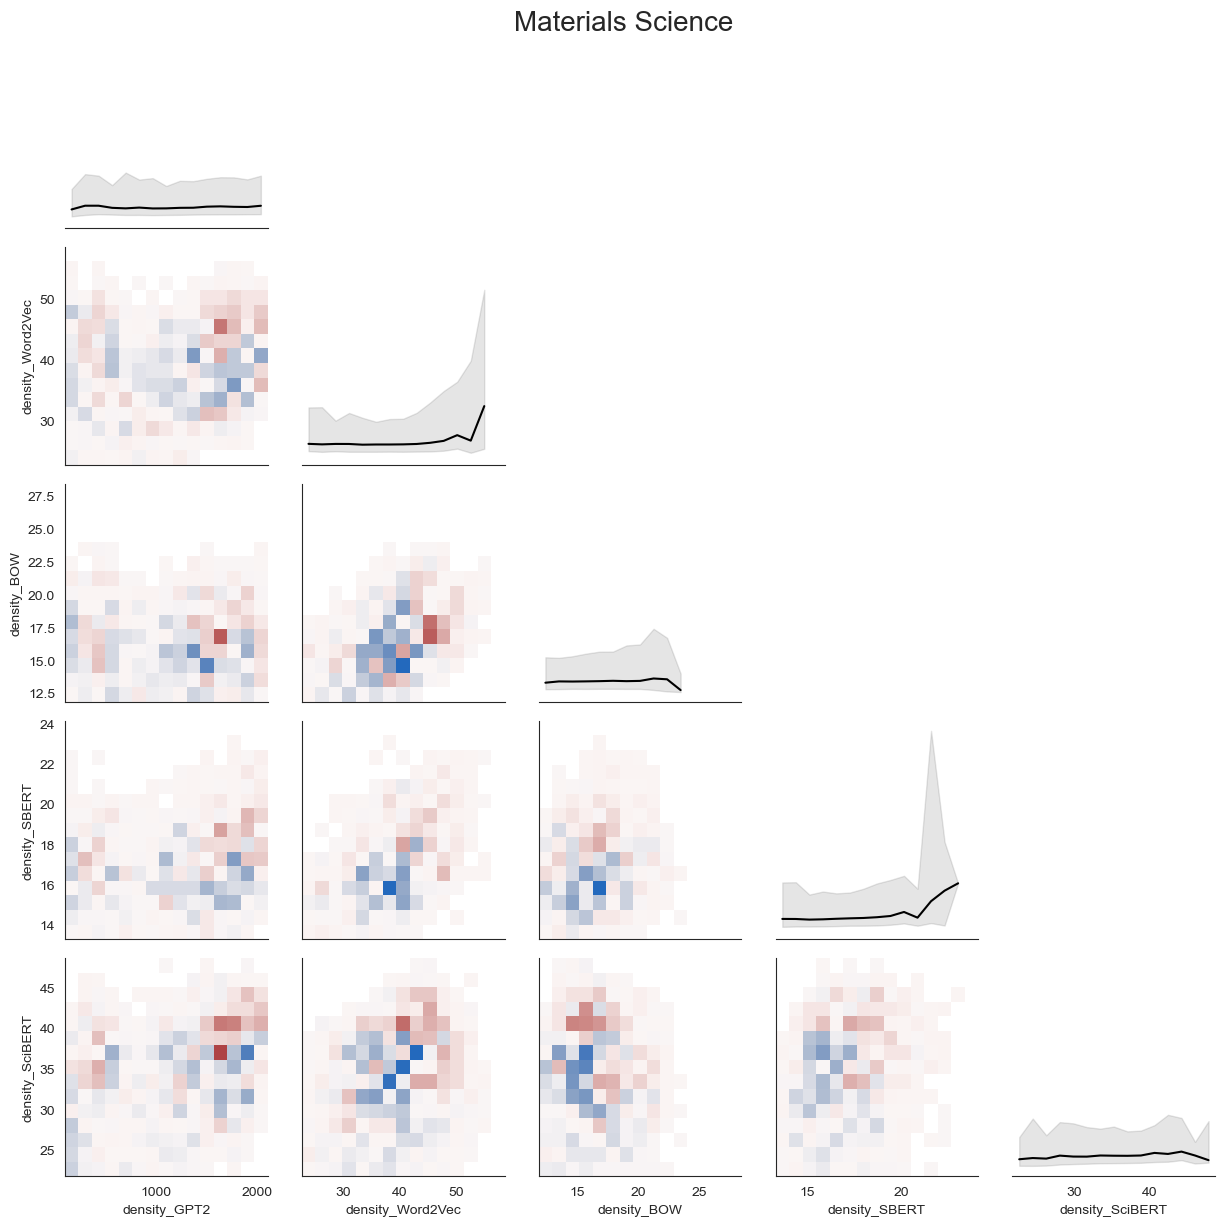

Distribution of cpy vs density for Mathematics


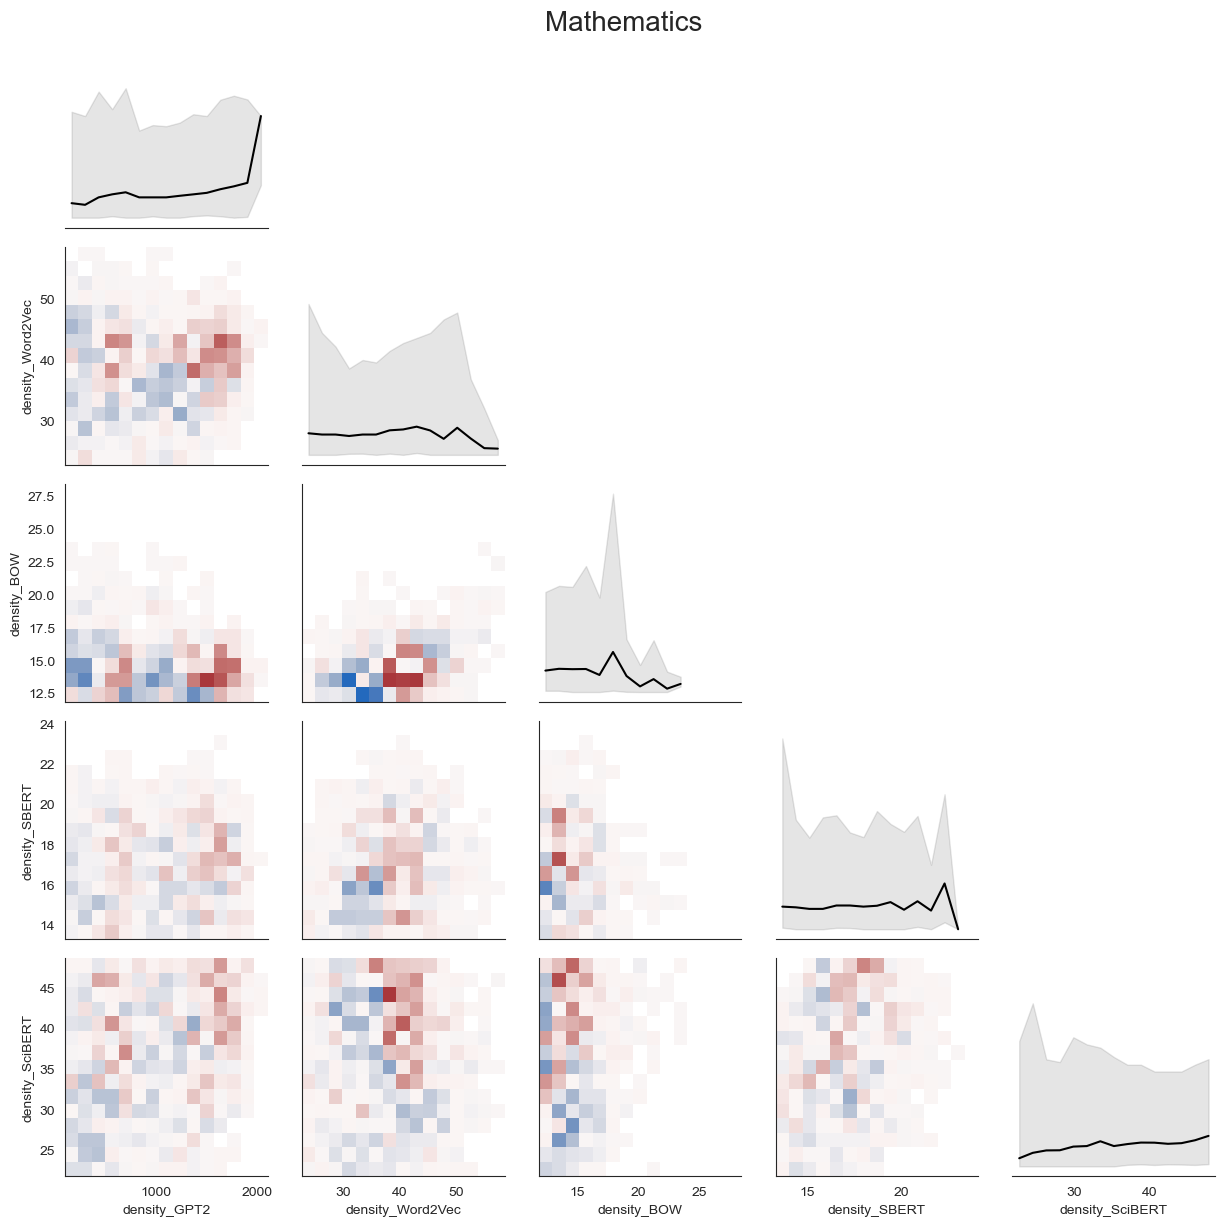

Distribution of cpy vs density for Medicine


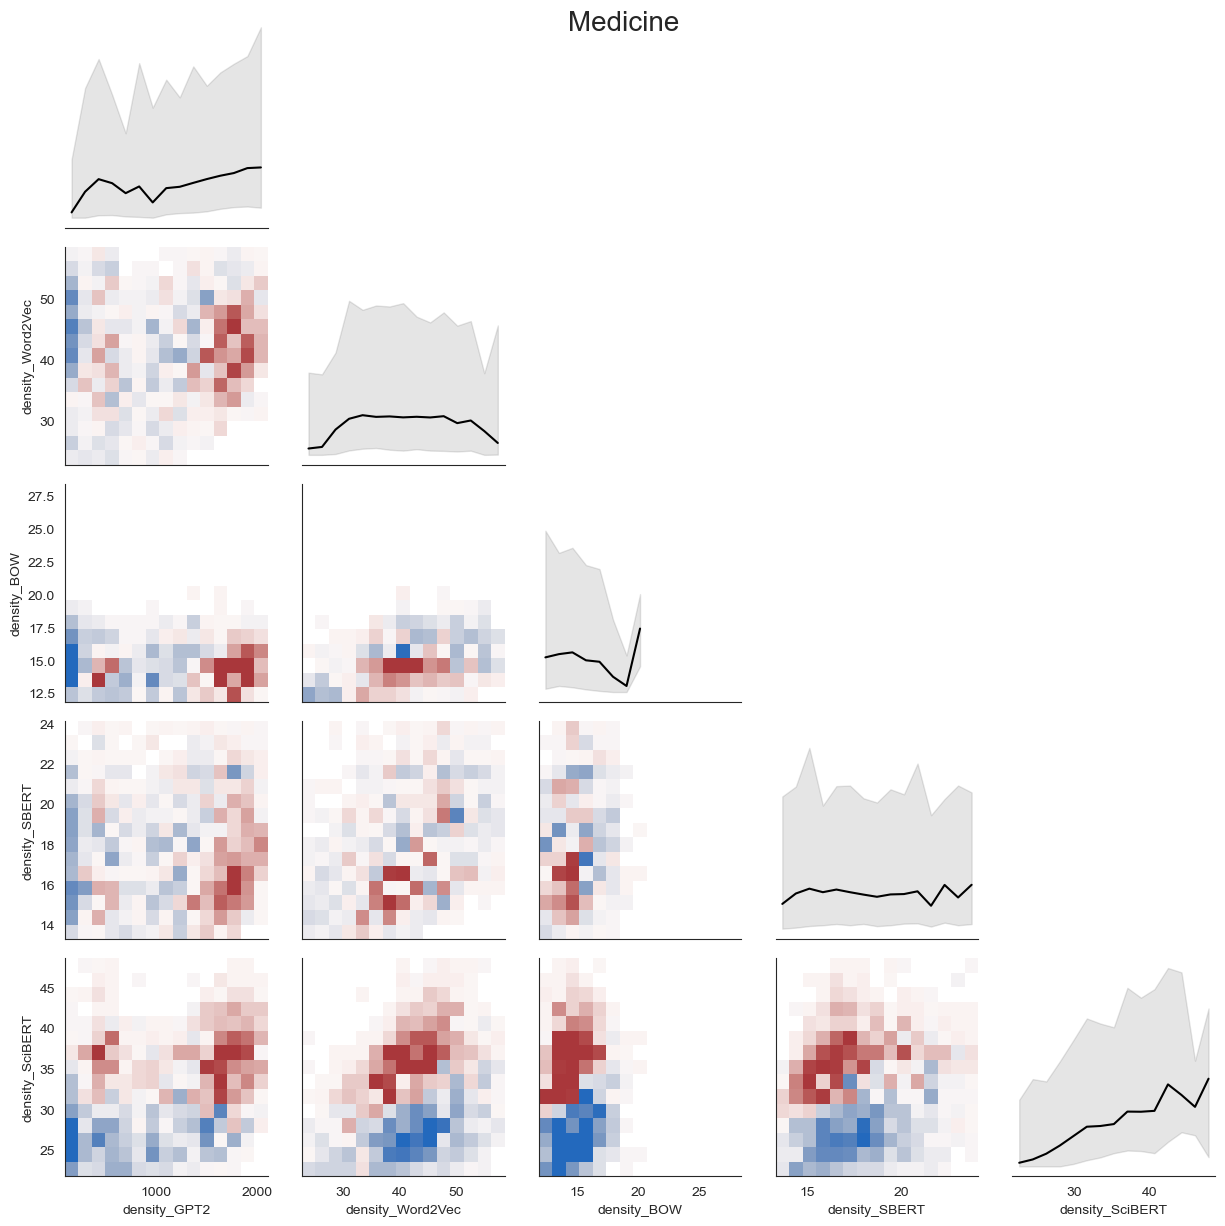

Distribution of cpy vs density for Philosophy


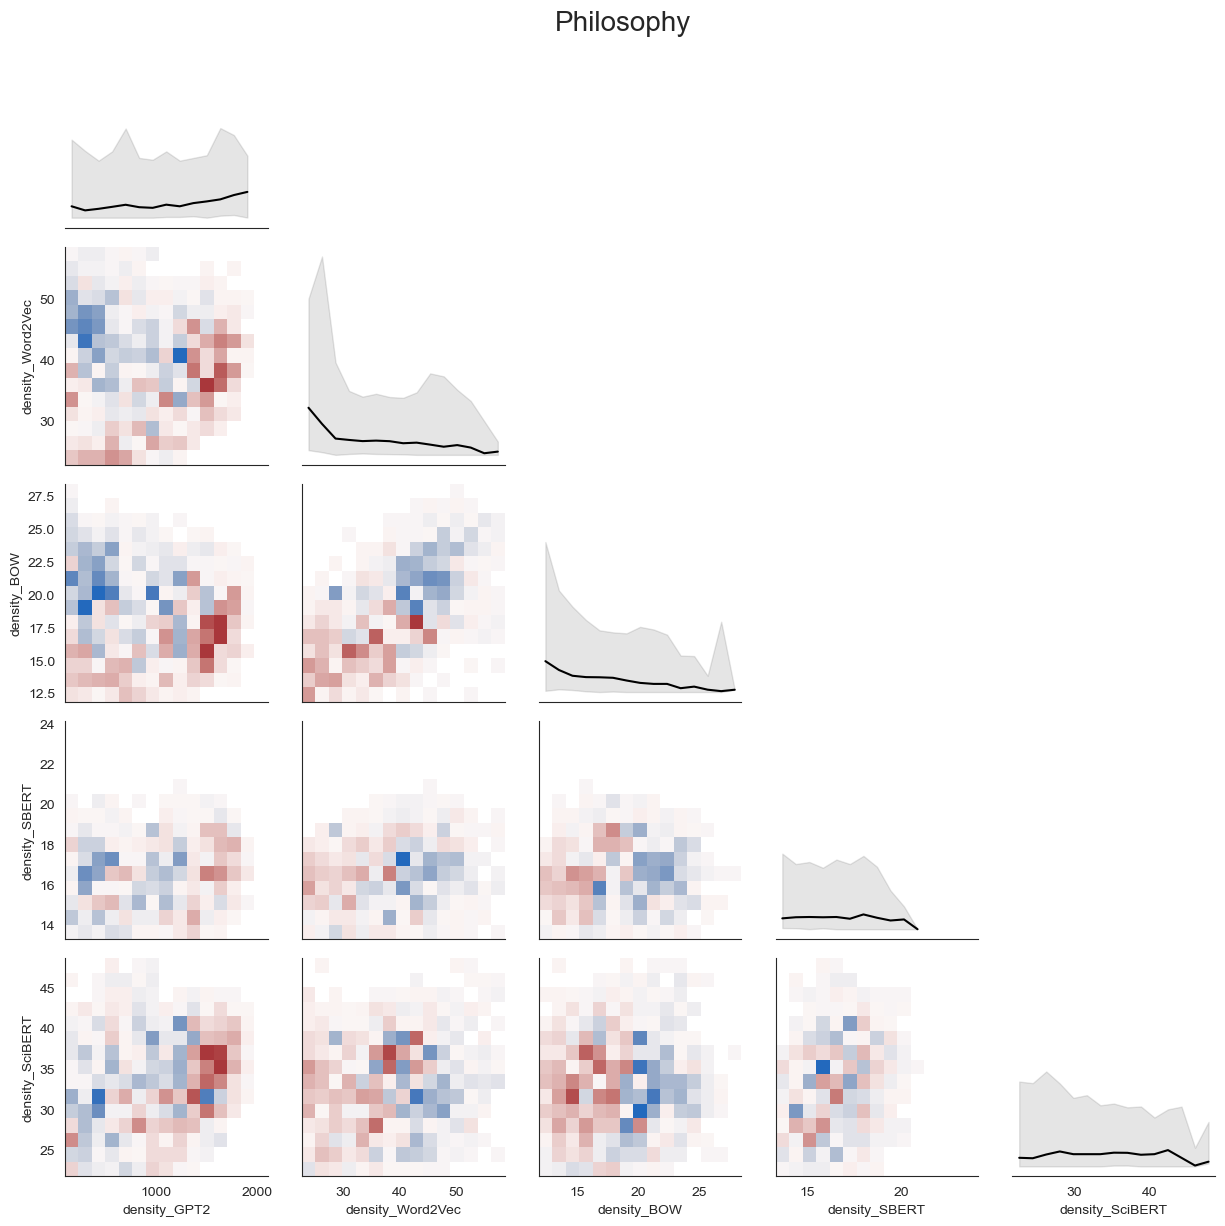

Distribution of cpy vs density for Physics


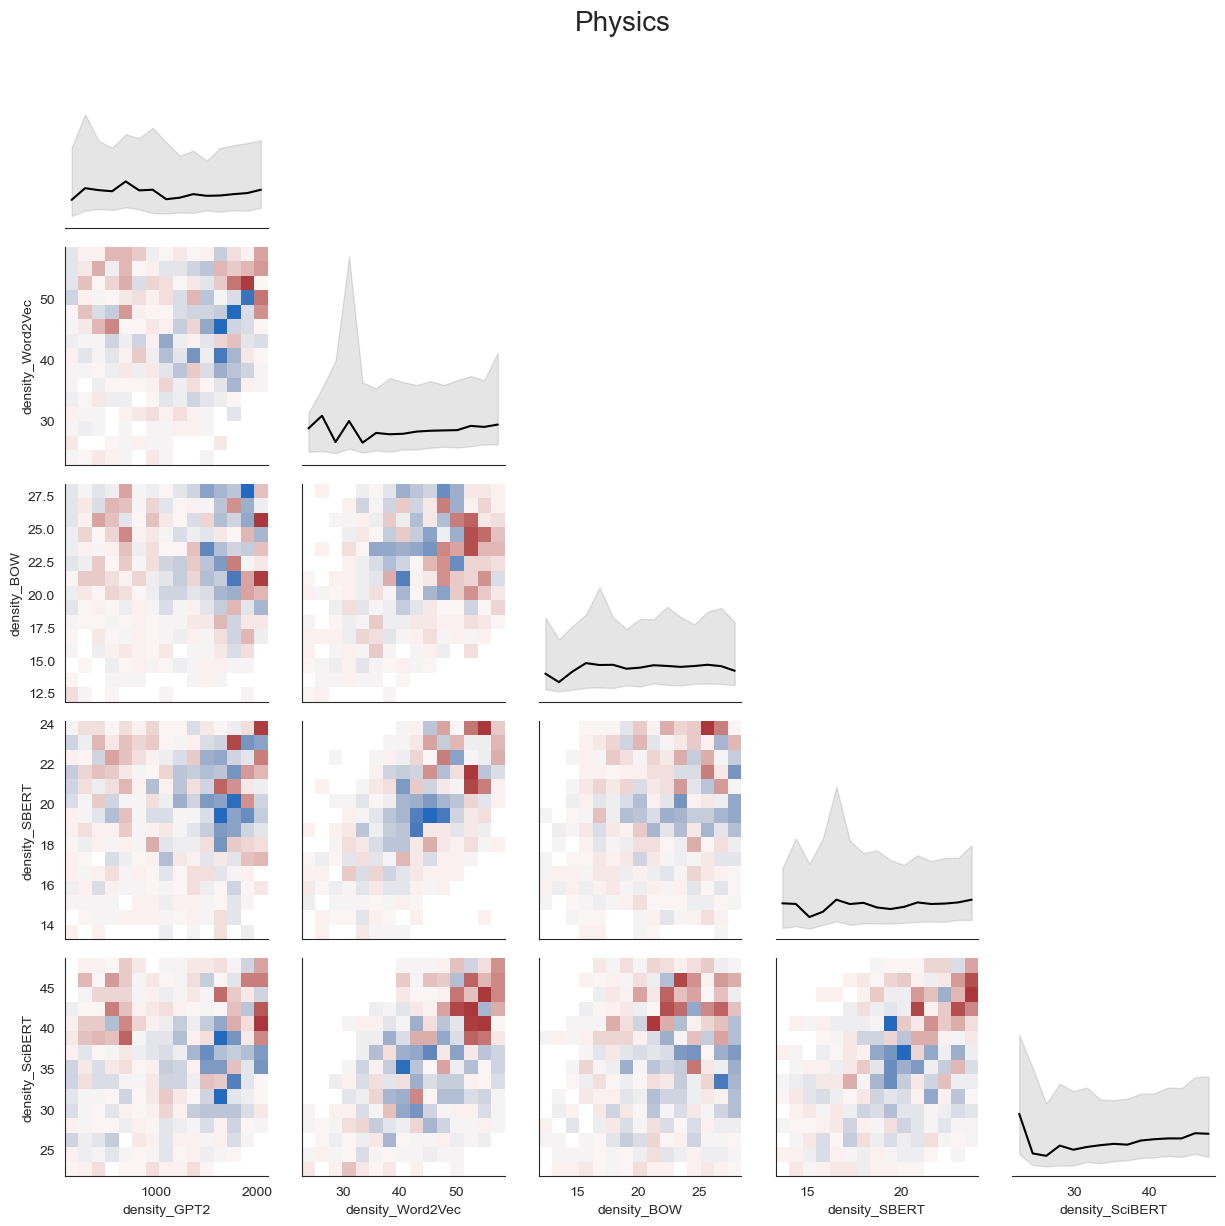

In [29]:
for field, group in grouped_df:

    print("Distribution of cpy vs density for", field)

    g = sns.PairGrid(group, vars=density_vars, corner=True)
    g.map_diag(cpy_vs_density, cpy=group["citations_per_year"])
    g.map_offdiag(median_cpy, cpy=group["citations_per_year"])
    plt.suptitle(field, fontsize=20)
    plt.show()
    g.figure.savefig(
        os.path.join(
            config["figure_dir"], f"cpy_vs_density_per_vectorizer_for_{field}.png"
        )
    )